# Text Classification of Clause Types


In [1]:
# To install only the requirements of this notebook, uncomment the lines below and run this cell

# ===========================
!pip install numpy==1.19.5
!pip install pandas==1.1.5
!pip install scikit-learn==0.21.3
!pip install matplotlib==3.2.2
# ===========================

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 64.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2022.12.0 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
xarray-einstats 0.4.0 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
tensorflow 2.9.2 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
jaxlib 0.3.25+cuda11.cudnn805 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
jax 0.3.25 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
cmdstanpy 1.0.8 requires numpy>=1.21, but 

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd # to work with csv files

# matplotlib imports are used to plot confusion matrices for the classifiers
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 

# import feature extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import stop_words

# pre-processing of text
import string
import re

# import classifiers from sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# import different metrics to evaluate the classifiers
from sklearn.metrics import accuracy_score

# from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn import metrics

# import time function from time module to track the training duration
from time import time

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdo

### Section 1: Load and explore the dataset

In [7]:
our_data = pd.read_csv('clause_type.csv')

display(our_data.shape) # Number of rows (instances) and columns in the dataset
our_data.head()

(6192, 3)

,Unnamed: 0,clause,type
0,0,BIRCH FIRST GLOBAL INVESTMENTS INC. MA Marketi...,Parties
1,1,EuroMedia Holdings Corp. Rogers Rogers Cable C...,Parties
2,2,Producer Fulucai Productions Ltd. ConvergTV CO...,Parties
3,3,PSiTech Corporation Licensor Licensee Empirica...,Parties
4,4,"YOU ON DEMAND HOLDINGS, INC. Licensor Licensee...",Parties


In [5]:
our_data["type"].value_counts()/our_data.shape[0] # Class distribution in the dataset

Parties                               0.082203
Agreement Date                        0.075904
Governing Law                         0.070575
Expiration Date                       0.066699
Effective Date                        0.062984
Anti-Assignment                       0.060401
Cap On Liability                      0.044412
License Grant                         0.041182
Audit Rights                          0.034561
Termination For Convenience           0.029554
Post-Termination Services             0.029393
Exclusivity                           0.029070
Renewal Term                          0.028424
Insurance                             0.026809
Revenue/Profit Sharing                0.026809
Minimum Commitment                    0.026647
Non-Transferable License              0.022287
Ip Ownership Assignment               0.020026
Change Of Control                     0.019541
Non-Compete                           0.019218
Notice Period To Terminate Renewal    0.017926
Uncapped Liab

In [13]:
classes = list(set(our_data["type"].values))

There is an imbalance in the data with **not relevant** being 82% in the dataset. That is, most of the clauses are not relevant. We should keep this class imbalance mind when interpreting the classifier performance later.

### Section 2: Text Pre-processing

Typical steps involve tokenization, lower casing, removing, stop words, punctuation markers etc, and vectorization. Other processes such as stemming/lemmatization can also be performed. Here, we are performing the following steps: removing br tags, punctuation, numbers, and stopwords. While we are using sklearn's list of stopwords, there are several other stop word lists (e.g., from NLTK) or sometimes, custom stopword lists are needed depending on the task. 

In [6]:
stopwords = stop_words.ENGLISH_STOP_WORDS
def clean(doc): # doc is a string of text
    doc = doc.replace("</br>", " ") # This text contains a lot of <br/> tags.
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stopwords])
    # remove punctuation and numbers
    return doc

### Section 3: Modeling

Now we are ready for the modelling. We are going to use algorithms from sklearn package. We will go through the following steps:

1 Split the data into training and test sets (75% train, 25% test)    
2 Extract features from the training data using CountVectorizer, which is a bag of words feature  implementation. We will use the pre-processing function above in conjunction with Count Vectorizer  
3 Transform the test data into the same feature vector as the training data.  
4 Train the classifier  
5 Evaluate the classifier  

In [8]:
import sklearn
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

# Step 1: train-test split
X = our_data.clause # the column text contains textual data to extract features from
y = our_data.type # this is the column we are learning to predict. 
print(X.shape, y.shape)
# split X and y into training and testing sets. By default, it splits 75% training and 25% test
# random_state=1 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6192,) (6192,)
(4644,) (4644,)
(1548,) (1548,)


In [9]:
# Step 2-3: Preprocess and Vectorize train and test data
vect = CountVectorizer(preprocessor=clean) # instantiate a vectoriezer
X_train_dtm = vect.fit_transform(X_train)# use it to extract features from training data
# transform testing data (using training data's features)
X_test_dtm = vect.transform(X_test)
print(X_train_dtm.shape, X_test_dtm.shape)
# i.e., the dimension of our feature vector is 49753!

(4644, 12319) (1548, 12319)


In [10]:
# Step 3: Train the classifier and predict for test data
nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train) # train the model(timing it with an IPython "magic command")
y_pred_class = nb.predict(X_test_dtm) # make class predictions for X_test_dtm

CPU times: user 42.7 ms, sys: 9.13 ms, total: 51.8 ms
Wall time: 52.8 ms


Accuracy:  0.6337209302325582


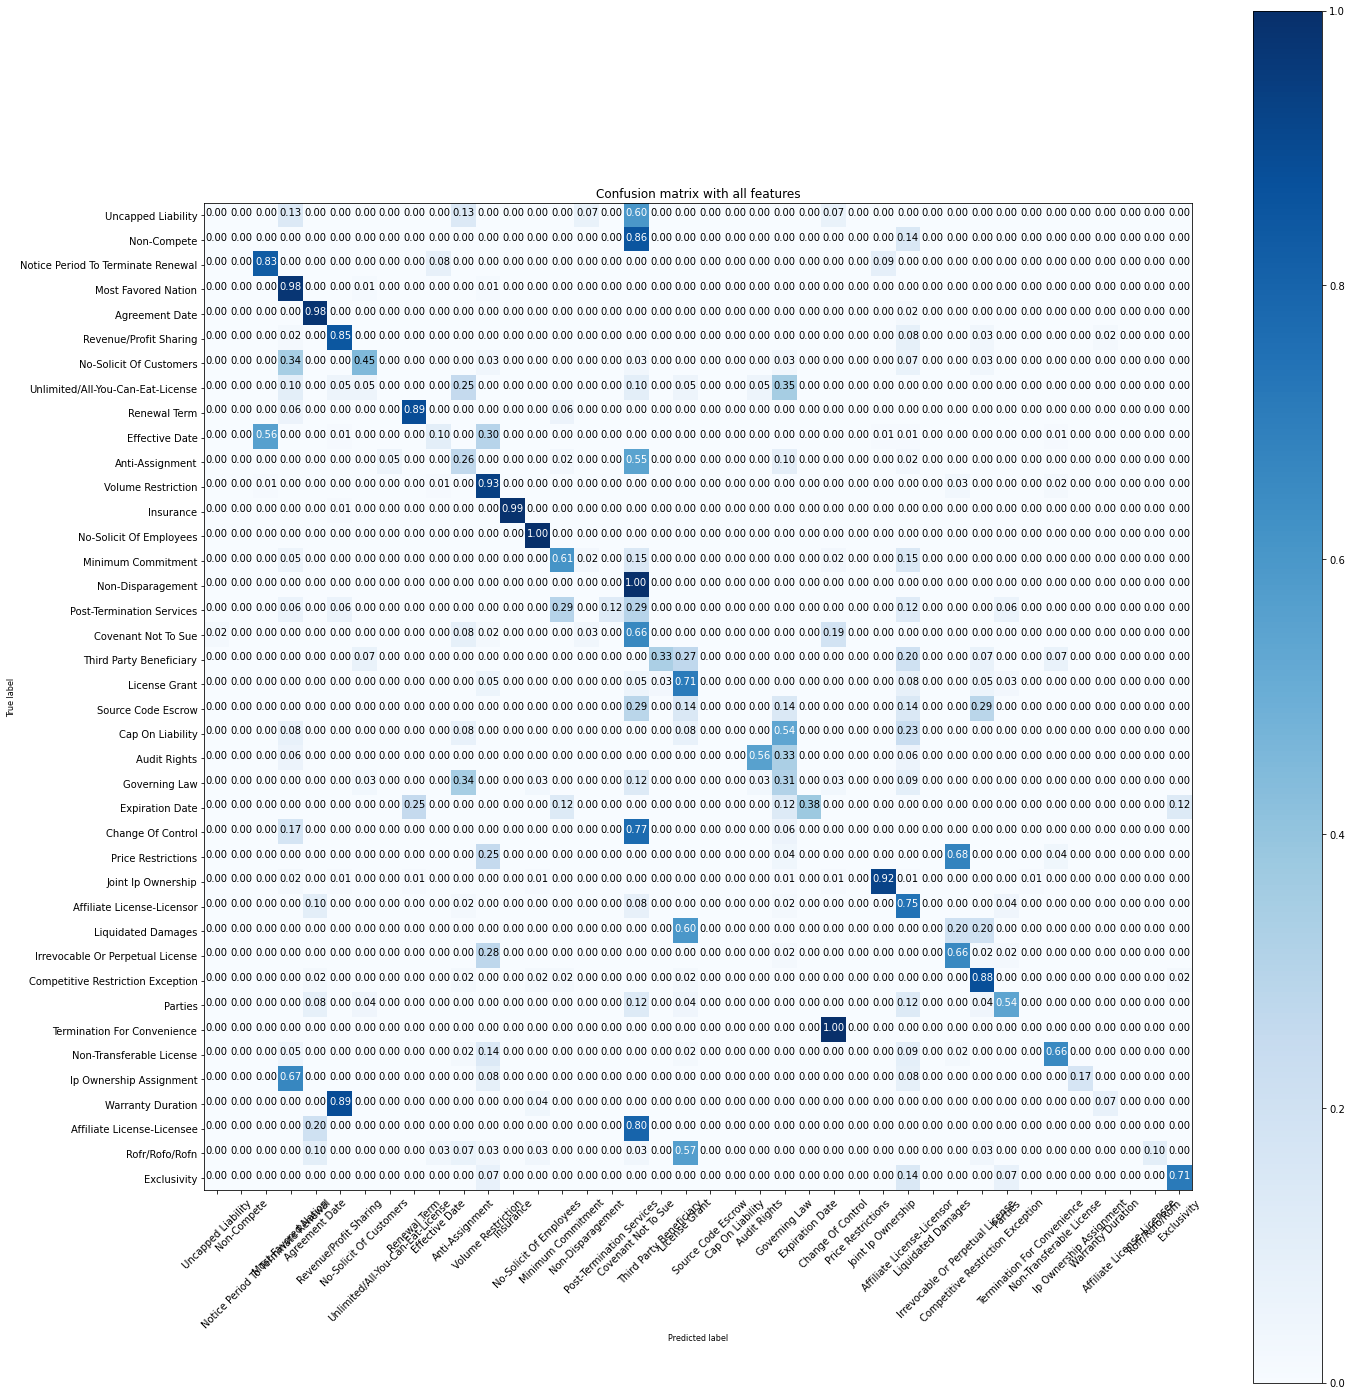

In [17]:
# Step 4: Evaluate the classifier using various measures

# Function to plot confusion matrix. 
# Ref:http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
from sklearn.metrics import roc_auc_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=8)
    plt.xlabel('Predicted label',fontsize=8)
    
    
# Print accuracy:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))

    
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cnf_matrix, classes=classes,normalize=True,
                      title='Confusion matrix with all features')

# calculate AUC: Area under the curve(AUC) gives idea about the model efficiency:
# Further information: https://en.wikipedia.org/wiki/Receiver_operating_characteristic
# y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
# print("ROC_AOC_Score: ", roc_auc_score(y_test, y_pred_prob))

At this point, we can notice that the classifier is doing poorly with identifying relevant clauses, while it is doing well with non-relevant ones. Our large feature vector could be creating a lot of noise in the form of very rarely occurring features that are not useful for learning. Let us change the count vectorizer to take a certain number of features as maximum. 

CPU times: user 28.6 ms, sys: 33 µs, total: 28.6 ms
Wall time: 28.6 ms
Accuracy:  0.6511627906976745


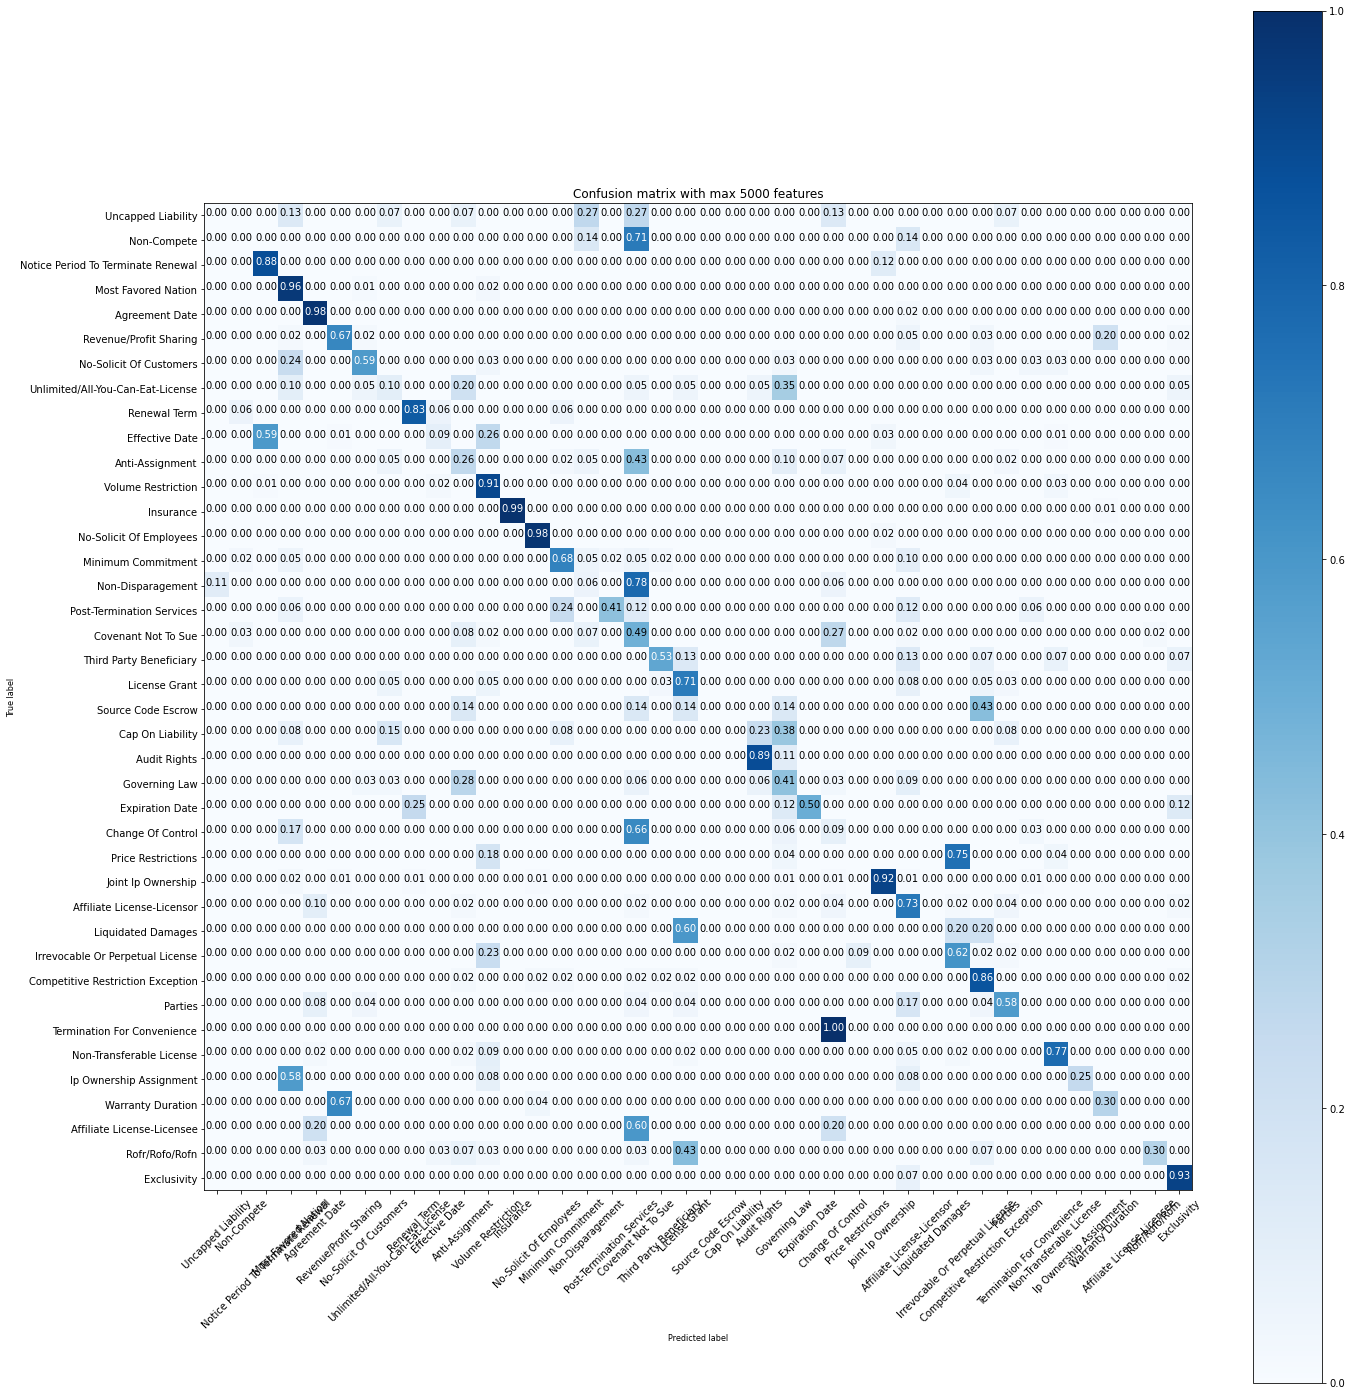

In [20]:
vect = CountVectorizer(preprocessor=clean, max_features=5000) # Step-1
X_train_dtm = vect.fit_transform(X_train) # combined step 2 and 3
X_test_dtm = vect.transform(X_test)
nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train) # train the model(timing it with an IPython "magic command")
y_pred_class = nb.predict(X_test_dtm) # make class predictions for X_test_dtm
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cnf_matrix, classes=classes,normalize=True,
                      title='Confusion matrix with max 5000 features')

Clearly, the performance on relevance classification got better even though the overall accuracy fell by 10%. For this experiment, I have considered logistic regression, with class_weight attribute as "balanced", to address the problem of class imbalance in this dataset. 


Accuracy:  0.7054263565891473


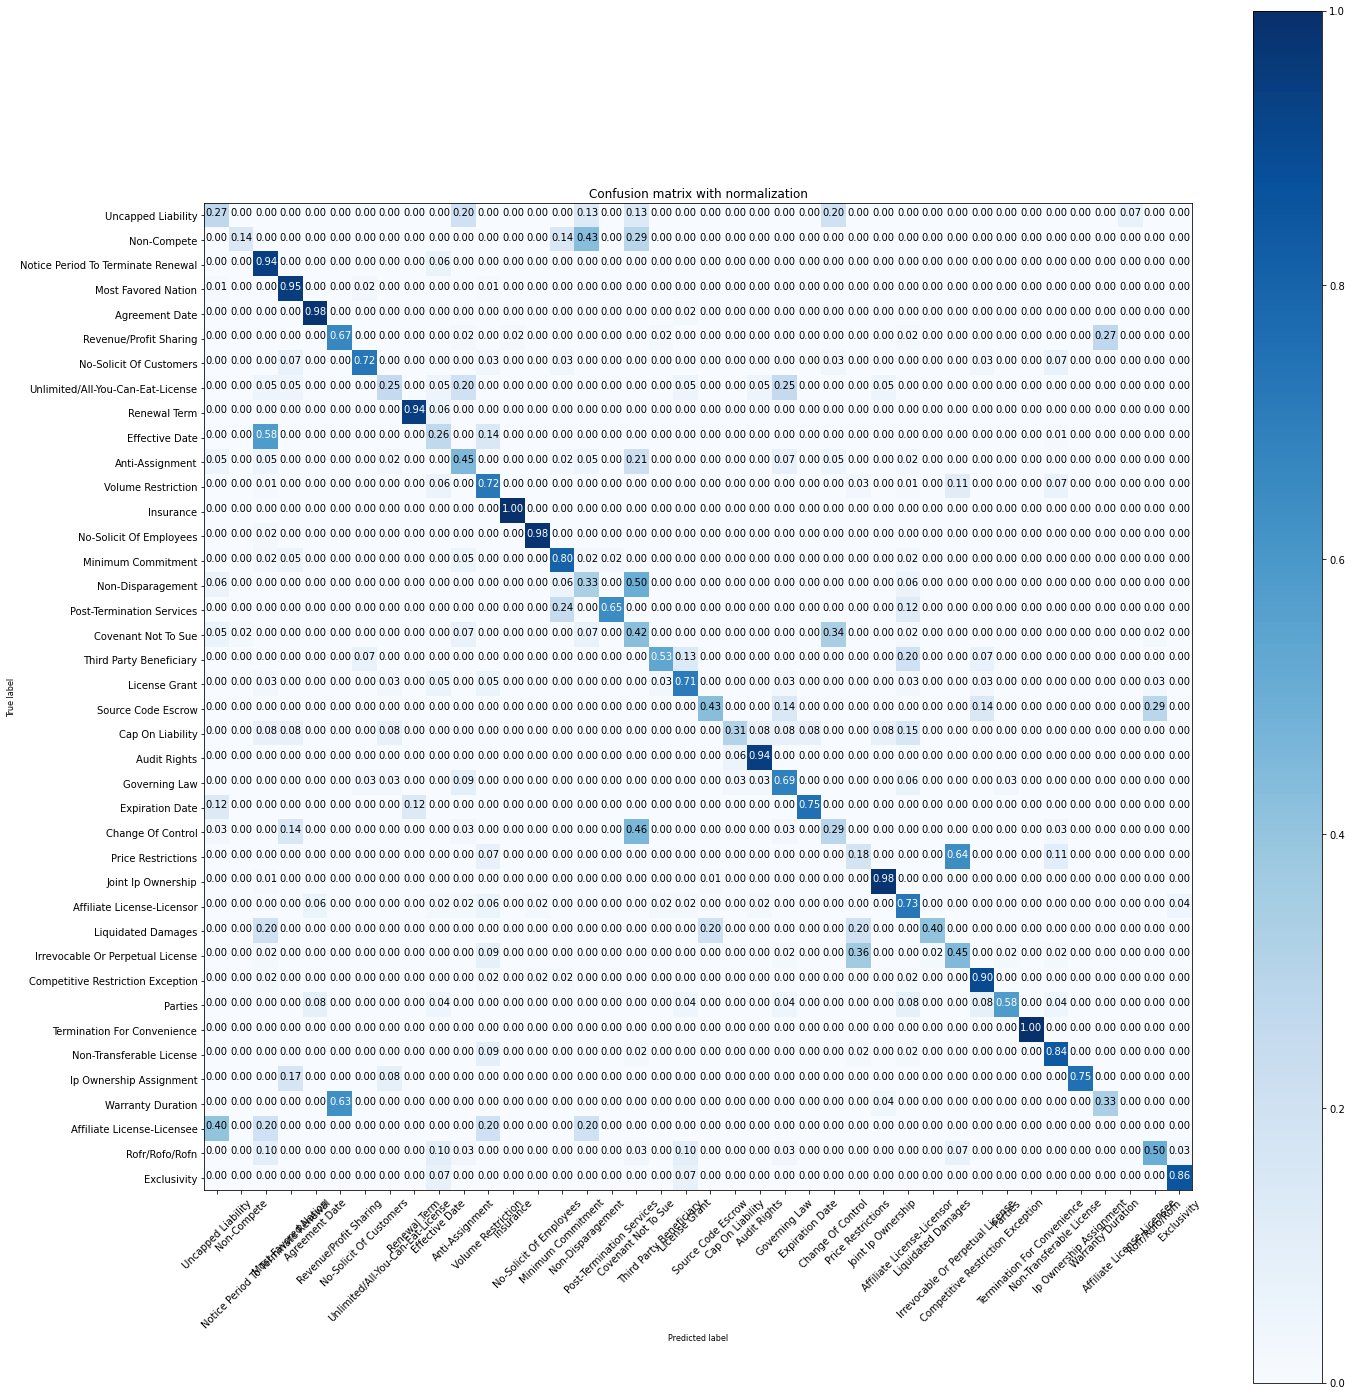

In [22]:
from sklearn.linear_model import LogisticRegression # import

logreg = LogisticRegression(class_weight="balanced") # instantiate a logistic regression model
logreg.fit(X_train_dtm, y_train) # fit the model with training data

# Make predictions on test data
y_pred_class = logreg.predict(X_test_dtm)

# calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cnf_matrix, classes=classes,normalize=True,
                      title='Confusion matrix with normalization')

Let us wrap this notebook by trying with one more classifier, but reducing the feature vector size to 1000.

Accuracy:  0.6569767441860465


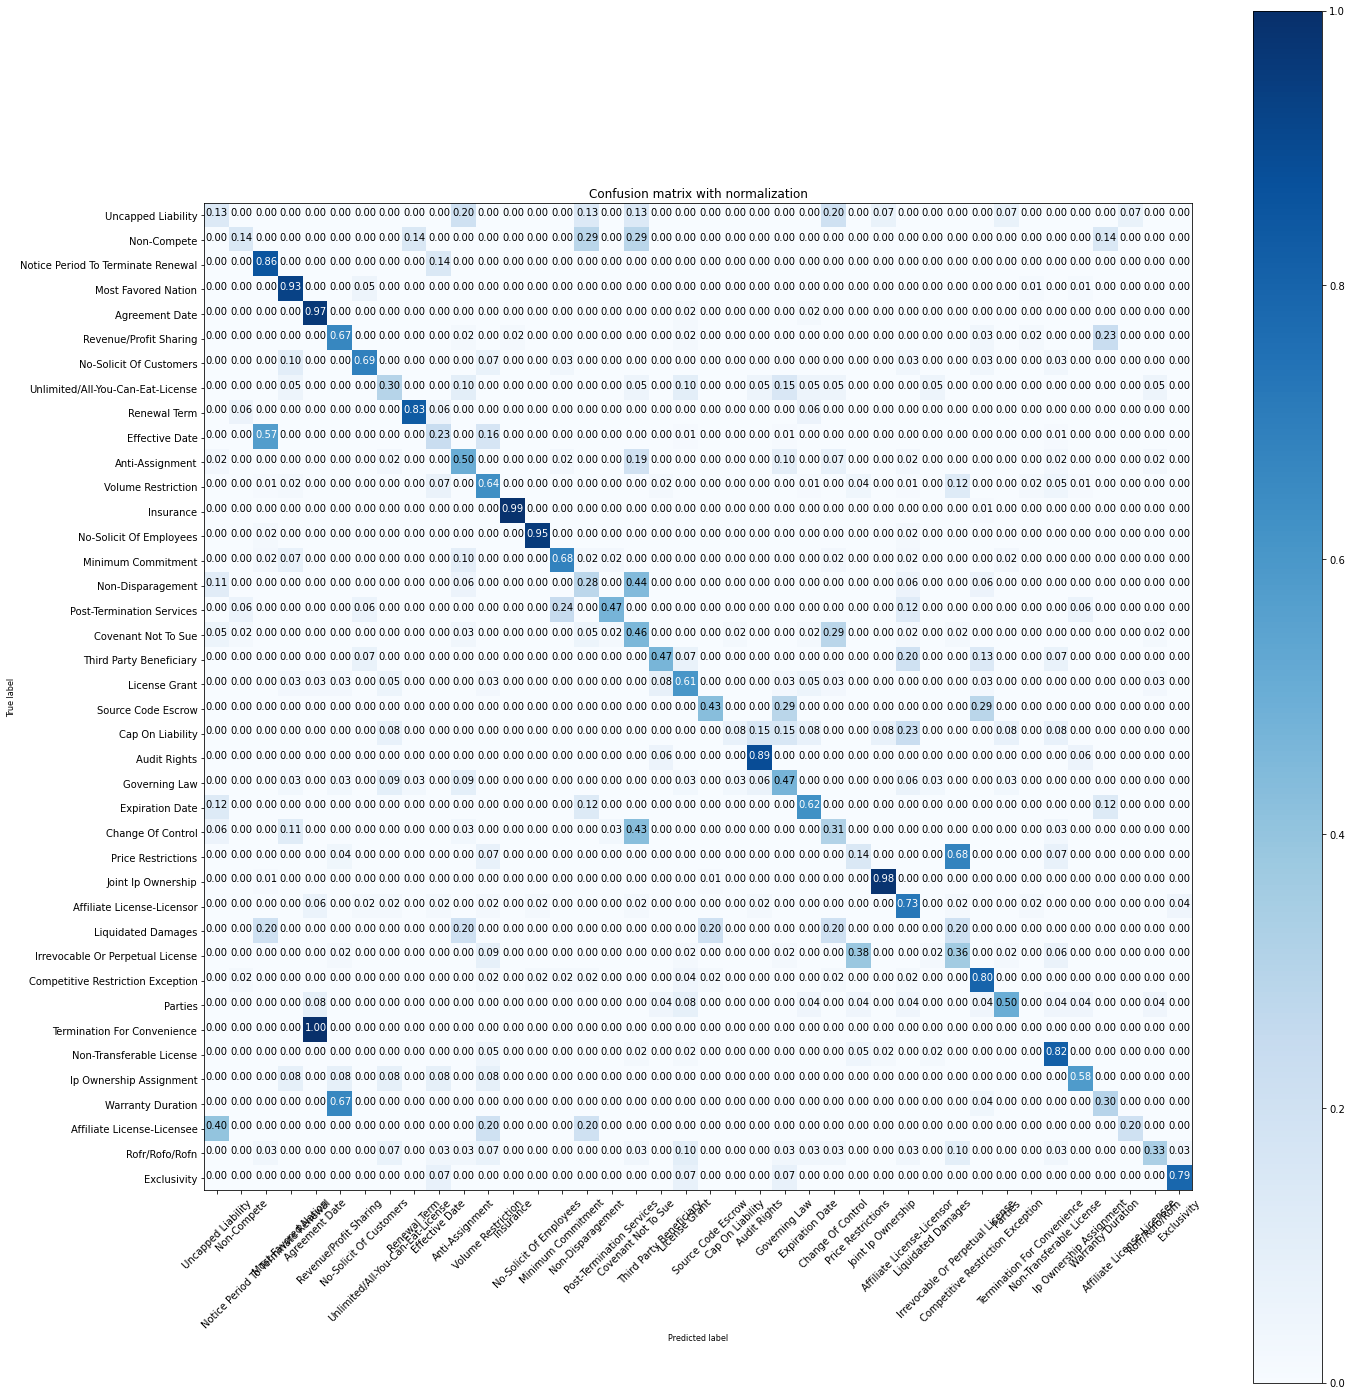

In [24]:
from sklearn.svm import LinearSVC

vect = CountVectorizer(preprocessor=clean, max_features=1000) # Step-1
X_train_dtm = vect.fit_transform(X_train) # combined step 2 and 3
X_test_dtm = vect.transform(X_test)

classifier = LinearSVC(class_weight='balanced') # instantiate a logistic regression model
classifier.fit(X_train_dtm, y_train) # fit the model with training data

# Make predictions on test data
y_pred_class = classifier.predict(X_test_dtm)

# calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cnf_matrix, classes=classes,normalize=True,
                      title='Confusion matrix with normalization')